Feature Construction examples and outlier clipping, revisiting the model from Exercise 1. First, we load in all the libraries.

(DISCLAIMER: There are alot of in line comments since I'm mainly recreating/slightly adjusting code from Google's MLCC. Try to bear with it because I'm learning as I go.)  

In [49]:
#to bring print function from later versions of python into this one
from __future__ import print_function
import math
from IPython import display

#for data visualization & interaction
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

#support for higher dimensional objects in data manipulation
import numpy as np
import pandas as pd
from sklearn import metrics


import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

#so we are not flooded with output anytime we print out the results
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Next, we load in our California housing data set just like last time. 

In [50]:
california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4074,-118.0,34.5,13.0,2815.0,535.0,1492.0,491.0,4.1,135.7
2413,-117.6,33.9,22.0,2620.0,396.0,1324.0,362.0,5.4,214.6
6273,-118.2,34.0,8.0,3105.0,1256.0,1086.0,997.0,0.8,275.0
10792,-120.7,35.3,26.0,4225.0,886.0,1795.0,704.0,2.3,247.0
1113,-117.1,34.5,17.0,1613.0,326.0,765.0,300.0,2.7,110.4
...,...,...,...,...,...,...,...,...,...
1152,-117.1,32.7,38.0,818.0,217.0,953.0,231.0,1.1,65.7
5022,-118.1,33.8,15.0,9103.0,1847.0,3333.0,1712.0,5.2,367.3
2684,-117.7,34.1,21.0,5662.0,1185.0,3067.0,1055.0,3.3,137.3
7144,-118.3,33.8,42.0,1486.0,420.0,897.0,377.0,1.6,376.1


And set up our input function. Just as a reminder, the input function is what we have to pass to TF to construct our regression estimators. It tells TF how to process, batch and shuffle the data.

In [51]:
"""Trains a linear regression model.
    Args: 
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Int size of batches to be passed to the model
        shuffle: Boolean of whether to shuffle the data
        epochs: Int Number of epochs for which data should be repeated.
            default value = None
    Returns:
        Tuple of (features, labels) for the next data batch
    
"""    
def my_input_func(features, targets, batch_size=1, shuffle=True, num_epochs = None):
        
        
        features = {key:np.array(value) for key, value in dict(features).items()}
        
        ds = Dataset.from_tensor_slices((features, targets))
        ds = ds.batch(batch_size).repeat(num_epochs)
        
        if shuffle:
            ds = ds.shuffle(buffer_size = 10000)
            
        #Creates iterator for the dataset and return next batch of data to Linear Regressor
        features, labels = ds.make_one_shot_iterator().get_next()
        return features, labels
    

        

Next, we create a train_model function that will train our linear regression model. 

In [52]:
"""Trains a Linear regression model.

    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
    Returns:
        Pandas 'Dataframe' that contains targets and corresponding predictions after model training
        Plots RMSE value at each training period step 
        Plots learned regression line at each training period
        
    """

def train_model(learning_rate, steps, batch_size, input_feature):
    
    periods = 10
    steps_per_period = steps/periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[input_feature]].astype('float32')
    my_label = "median_house_value"
    targets = california_housing_dataframe["median_house_value"].astype('float32')
    
    #Create the input functions
    training_input_func = lambda: my_input_func(my_feature_data, targets, batch_size = batch_size)
    predict_training_input_func = lambda: my_input_func(my_feature_data, targets, num_epochs = 1, shuffle = False)
    
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    #Configure and set up linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    #Setup for plotting of learned regression line over training periods
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Learned Line by Period")
    plt.xlabel(my_label)
    plt.ylabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1,1,periods)]
    
    #Train model inside loop to periodically assess loss metrics
    
    print("Training model...")
    print("RMSE (TRAINING DATA)")
    root_mean_squared_errors = []
    
    
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_func,
            steps=steps_per_period,
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=predict_training_input_func)
        predictions = np.array([item['predictions'][0] for item in predictions])

        # Compute loss.
        root_mean_squared_error = math.sqrt(
          metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])

        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                               sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Create a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

    return calibration_data

    

Phew... Now lets see if we can do any better than last time if we construct an artificial feature. The idea proposed in the tutorial is the idea of population density and for the purposes of not getting too ahead of myself, I'm going to stick with it.

We calculate Density in the following way: Total_Rooms/Population



Training model...
RMSE (TRAINING DATA)
  period 00 : 189.67
  period 01 : 151.66
  period 02 : 133.79
  period 03 : 130.75
  period 04 : 132.43
  period 05 : 133.77
  period 06 : 132.03
  period 07 : 135.37
  period 08 : 133.38
  period 09 : 133.07
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,205.3,207.3
std,93.5,116.0
min,48.3,15.0
25%,168.6,119.4
50%,202.1,180.4
75%,230.6,265.0
max,4463.0,500.0


Final RMSE (on training data): 133.07


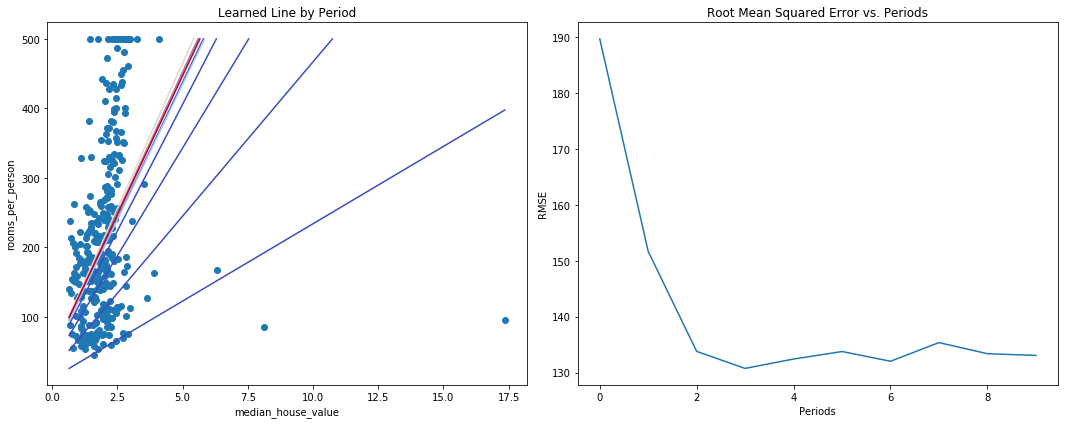

In [53]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"]

calibration_data = train_model(
    learning_rate = 0.05,
    steps = 1000,
    batch_size = 5,
    input_feature = "rooms_per_person"
    
)

Lets make a scatter plot of our predictions vs. targets and see if we can figure out whats going on here. 


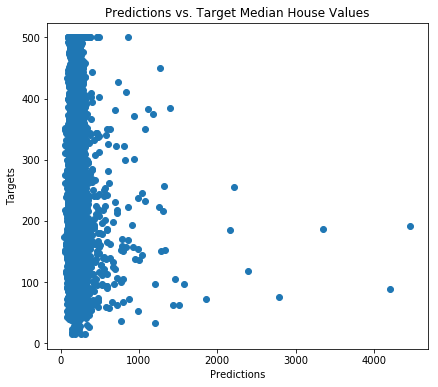

In [54]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
plt.ylabel('Targets')
plt.xlabel('Predictions')
plt.title("Predictions vs. Target Median House Values")
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

Lets take a look at the histogram of our room_per_person data to see if we can figure out why some predictions are excessively innacurate.


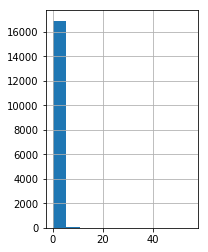

In [55]:
plt.subplot(1,2,1)

california_housing_dataframe["rooms_per_person"].hist()

Essentially, the few outliers in our room_per_person feature set corresponding to excessivly large house prices are distorting our regression estimates, driving down the slope estimate in our regression line. 

So, like all good statisticians do, lets delete this data. 

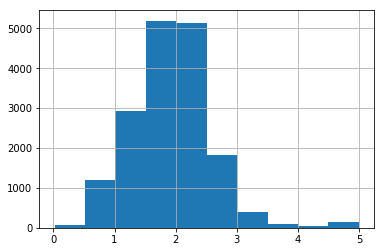

In [56]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x,5))

california_housing_dataframe["rooms_per_person"].hist()

Alright, lets see if this helped our regression estimates

Training model...
RMSE (TRAINING DATA)
  period 00 : 189.02
  period 01 : 147.10
  period 02 : 119.43
  period 03 : 109.41
  period 04 : 108.23
  period 05 : 107.96
  period 06 : 107.90
  period 07 : 108.02
  period 08 : 107.98
  period 09 : 107.96
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,208.2,207.3
std,55.4,116.0
min,45.7,15.0
25%,172.8,119.4
50%,208.3,180.4
75%,238.4,265.0
max,466.8,500.0


Final RMSE (on training data): 107.96


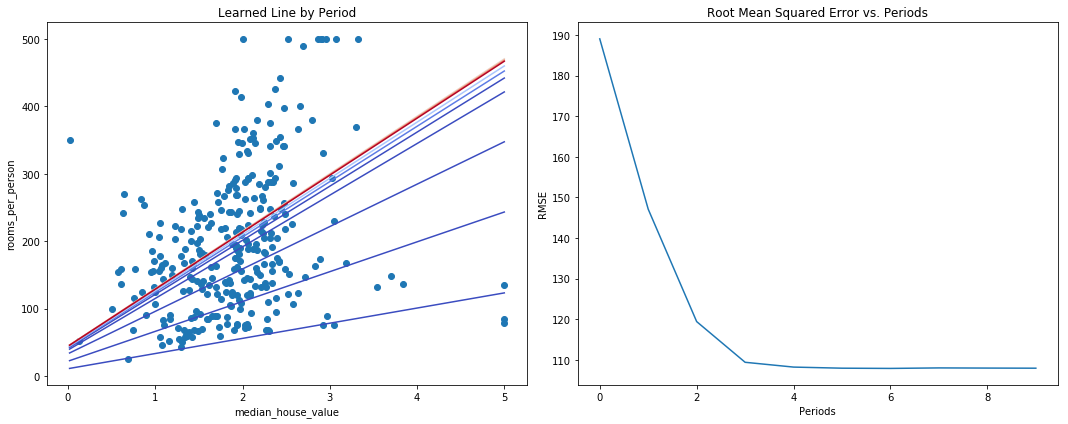

In [57]:
calibration_data = train_model(
    learning_rate = 0.05,
    steps = 1000,
    batch_size = 5,
    input_feature = "rooms_per_person"
    
)

There we go, much better. Still not a great model obviously but baby steps. 

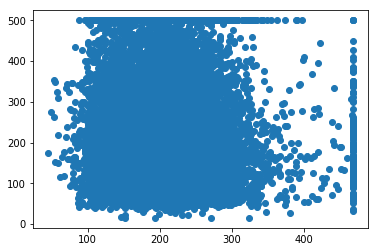

In [58]:
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

Ideally we would want the dots to converge to the line y=x but considering only 1 feature